In [1]:
import torch
import torch.nn.functional as F
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

torch.manual_seed(1024)

In [2]:
# 定义线性模型和Sigmoid函数

class Linear:
    
    def __init__(self, in_features, out_features, bias=True):
        '''
        模型参数初始化
        需要注意的是，此次故意没做参数初始化的优化
        '''
        self.weight = torch.randn((in_features, out_features), requires_grad=True)   # (in_features, out_features)
        self.bias = torch.randn(out_features, requires_grad=True) if bias else None  # (             out_features)
        
    def __call__(self, x):
        #           x: (B, in_features)
        # self.weight:    (in_features, out_features)
        self.out = x @ self.weight  # (B, out_features)
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        '''
        返回线性模型的参数，主要用于参数迭代更新
        由于PyTorch的计算单元就是张量，
        所以此次只需将不同参数简单合并成列表即可
        '''
        if self.bias is not None:
            return [self.weight, self.bias]
        return [self.weight]


class Sigmoid:
    
    def __call__(self, x):
        self.out = torch.sigmoid(x)
        return self.out
    
    def parameters(self):
        '''
        Sigmoid函数没有模型参数
        '''
        return []

In [3]:
class Sequential:
    
    def __init__(self, layers):
        # layers表示的模型组件，比如线性模型，比如sigmoid
        self.layers = layers
        
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [4]:
def train_model(model, data, max_steps):
    lossi = []
    # 记录各层的参数更新幅度
    # {1: [...], 2: [...]}
    udi = {}
    x, y = torch.tensor(data[0]).float(), torch.tensor(data[1])
    learning_rate = 0.01
    
    for i in range(max_steps):
        # 向前传播
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        # 保留中间节点的梯度，以便观察
        for layer in model.layers:
            layer.out.retain_grad()
        for p in model.parameters():
            p.grad = None
        # 反向传播
        loss.backward()
        # 更新模型参数
        with torch.no_grad():
            for i, p in enumerate(model.parameters()):
                p -= learning_rate * p.grad
                udi[i] = udi.get(i, []) + [(learning_rate * p.grad).std() / p.std()]
        lossi.append(loss.item())
    return lossi, udi

In [8]:
data = make_moons(2000, noise=0.05)

# 为了讨论的方便，将神经网络扩大
n_hidden = 100
model = Sequential([
    Linear(       2, n_hidden), Sigmoid(),
    Linear(n_hidden, n_hidden), Sigmoid(),
    Linear(n_hidden, n_hidden), Sigmoid(),
    Linear(n_hidden, n_hidden), Sigmoid(),
    Linear(n_hidden,        2)
])

train_model(model, data, 1)

([4.795090198516846],
 {0: [tensor(0.0006)],
  1: [tensor(0.0010)],
  2: [tensor(0.0003)],
  3: [tensor(0.0005)],
  4: [tensor(0.0003)],
  5: [tensor(0.0005)],
  6: [tensor(0.0004)],
  7: [tensor(0.0006)],
  8: [tensor(0.0029)],
  9: [tensor(0.0109)]})

In [11]:
# 监控激活函数的输出
def saturation_stats(model):
    for i, layer in enumerate(model.layers):
        if isinstance(layer, Sigmoid):
            t = layer.out
            # 当激活函数的输出大于0.99或者小于0.01的时候，我们就认为激活函数过热
            # 计算过热比例
            saturation = ((t - 0.5).abs() > 0.49).float().mean()
            # 激活函数的输出分布情况
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            print(f'layer {i} mean {t.mean():.2f} std {t.std():.2f} saturation {saturation:.2f}')
    plt.show()

layer 1 mean 0.49 std 0.26 saturation 0.00
layer 3 mean 0.49 std 0.42 saturation 0.37
layer 5 mean 0.49 std 0.45 saturation 0.56
layer 7 mean 0.41 std 0.43 saturation 0.49


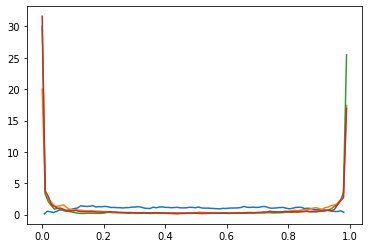

In [12]:
saturation_stats(model)

In [15]:
def grad_stats(model):
    # 输出层暂不讨论
    for i, layer in enumerate(model.layers[:-1]):
        if isinstance(layer, Linear):
            w = layer.parameters()[0]
            g = w.grad
            grad_ratio = g.std() / w.std()
            # 参数梯度的分布情况
            hy, hx = torch.histogram(g, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            print(f'layer {i} mean {g.mean():.2f} std {g.std():.2f} grad_ratio {grad_ratio:.2f}')
    plt.show()

layer 0 mean 0.00 std 0.06 grad_ratio 0.06
layer 2 mean 0.00 std 0.03 grad_ratio 0.03
layer 4 mean 0.00 std 0.03 grad_ratio 0.03
layer 6 mean -0.00 std 0.04 grad_ratio 0.04


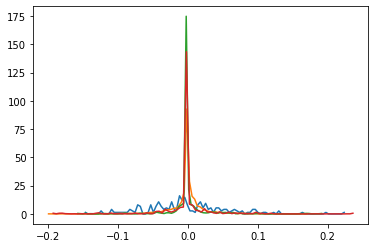

In [16]:
grad_stats(model)

In [17]:
_, ud = train_model(model, data, 100)

In [20]:
def grad_ratio_plot(model):
    legends = []
    for i, p in enumerate(model.parameters()[:-2]):
        if p.ndim == 2:
            plt.plot([t.log10().item() for t in ud[i]])
            legends.append(f'layer {i} {p.shape}')
    plt.legend(legends)
    plt.show()

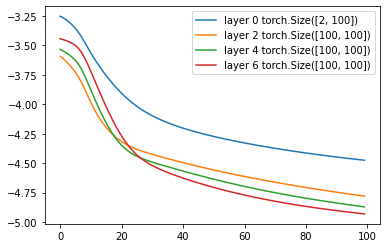

In [21]:
grad_ratio_plot(model)

In [22]:
# 随机猜测的模型损失
-torch.tensor(0.5).log()

tensor(0.6931)

In [23]:
clz_num = 2
num = 1000
logits = torch.randn(num, clz_num)
y = torch.randint(clz_num, (num,))
F.cross_entropy(logits, y)

tensor(0.8447)

In [24]:
clz_num = 2
num = 1000
logits = torch.randn(num, clz_num) * 10
y = torch.randint(clz_num, (num,))
F.cross_entropy(logits, y)

tensor(5.6338)

In [29]:
data = make_moons(2000, noise=0.05)

# 为了讨论的方便，将神经网络扩大
n_hidden = 100
model = Sequential([
    Linear(       2, n_hidden), Sigmoid(),
    Linear(n_hidden, n_hidden), Sigmoid(),
    Linear(n_hidden, n_hidden), Sigmoid(),
    Linear(n_hidden, n_hidden), Sigmoid(),
    Linear(n_hidden,        2)
])

# 参数初始化的优化
with torch.no_grad():
    for layer in model.layers:
        if isinstance(layer, Linear):
            in_features, out_features = layer.weight.shape
            layer.weight *= 1 / in_features ** 0.5
            layer.bias = torch.zeros(out_features, requires_grad=True)

train_model(model, data, 1)

([0.7606934309005737],
 {0: [tensor(1.0919e-06)],
  1: [tensor(1.)],
  2: [tensor(1.7928e-05)],
  3: [tensor(1.)],
  4: [tensor(7.9178e-05)],
  5: [tensor(1.)],
  6: [tensor(0.0003)],
  7: [tensor(1.)],
  8: [tensor(0.0089)],
  9: [tensor(1.)]})

layer 1 mean 0.51 std 0.17 saturation 0.00
layer 3 mean 0.51 std 0.14 saturation 0.00
layer 5 mean 0.50 std 0.12 saturation 0.00
layer 7 mean 0.51 std 0.12 saturation 0.00


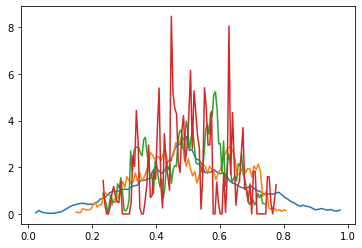

In [32]:
saturation_stats(model)

layer 0 mean -0.00 std 0.00 grad_ratio 0.00
layer 2 mean -0.00 std 0.00 grad_ratio 0.00
layer 4 mean 0.00 std 0.00 grad_ratio 0.01
layer 6 mean 0.00 std 0.00 grad_ratio 0.03


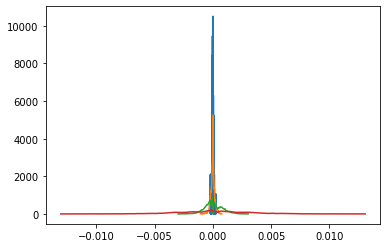

In [33]:
grad_stats(model)

In [34]:
_, ud = train_model(model, data, 100)

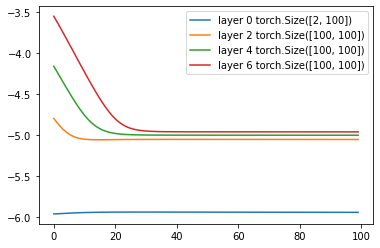

In [35]:
grad_ratio_plot(model)

In [38]:
@torch.no_grad()
def layer_stats(func, calculate_gain):
    x = torch.randn(300, 1000)
    for t in range(10):
        l = Linear(1000, 1000, bias=False)
        in_features, _ = l.weight.shape
        # 初步优化
        l.weight *= 1 / in_features ** 0.5
        # 做进一步的优化
        l.weight *= calculate_gain
        x = func(l(x))
        hy, hx = torch.histogram(x, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        print(f'layer {t} mean {x.mean():.2f} std {x.std():.2f}')

layer 0 mean 0.50 std 0.21
layer 1 mean 0.50 std 0.13
layer 2 mean 0.50 std 0.12
layer 3 mean 0.50 std 0.12
layer 4 mean 0.50 std 0.12
layer 5 mean 0.50 std 0.12
layer 6 mean 0.51 std 0.12
layer 7 mean 0.50 std 0.12
layer 8 mean 0.50 std 0.12
layer 9 mean 0.50 std 0.12


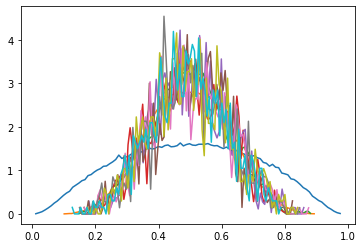

In [39]:
layer_stats(torch.sigmoid, 1.0)

layer 0 mean -0.00 std 0.72
layer 1 mean 0.00 std 0.63
layer 2 mean -0.00 std 0.59
layer 3 mean -0.00 std 0.57
layer 4 mean -0.00 std 0.56
layer 5 mean 0.00 std 0.56
layer 6 mean 0.00 std 0.55
layer 7 mean 0.00 std 0.55
layer 8 mean 0.00 std 0.55
layer 9 mean 0.00 std 0.55


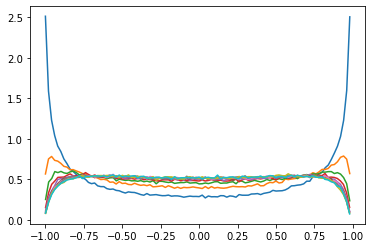

In [42]:
layer_stats(torch.tanh, 1.4)

layer 0 mean 0.56 std 0.83
layer 1 mean 0.57 std 0.82
layer 2 mean 0.58 std 0.84
layer 3 mean 0.58 std 0.86
layer 4 mean 0.58 std 0.86
layer 5 mean 0.63 std 0.89
layer 6 mean 0.66 std 0.94
layer 7 mean 0.65 std 0.97
layer 8 mean 0.66 std 0.97
layer 9 mean 0.69 std 1.02


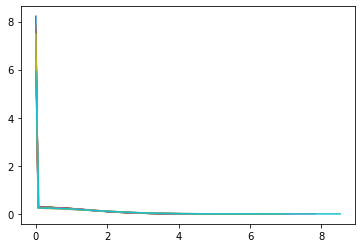

In [48]:
layer_stats(torch.relu, torch.tensor(2).sqrt())

In [49]:
class BatchNorm1d:
    # x : (B, f)
    
    def __init__(self, dim, eps=1e-5):
        self.eps = eps
        self.gamma = torch.ones(dim, requires_grad=True)  # (f)
        self.beta = torch.zeros(dim, requires_grad=True)  # (f)
        
    def __call__(self, x):
        # x : (B, f)
        xmean = x.mean(0, keepdim=True)  # (1, f)
        xvar = x.var(0, keepdim=True)    # (1, f)
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # (B, f)
        self.out = self.gamma * xhat + self.beta  # (B, f)
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

In [50]:
@torch.no_grad()
def layer_stats2(func):
    x = torch.randn(300, 1000)
    for t in range(10):
        l = Linear(1000, 1000, bias=False)
        b = BatchNorm1d(1000)
        #in_features, _ = l.weight.shape
        # 初步优化
        #l.weight *= 1 / in_features ** 0.5
        # 做进一步的优化
        #l.weight *= calculate_gain
        x = func(b(l(x)))
        hy, hx = torch.histogram(x, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        print(f'layer {t} mean {x.mean():.2f} std {x.std():.2f}')

layer 0 mean 0.40 std 0.58
layer 1 mean 0.40 std 0.58
layer 2 mean 0.40 std 0.58
layer 3 mean 0.40 std 0.58
layer 4 mean 0.40 std 0.58
layer 5 mean 0.40 std 0.58
layer 6 mean 0.40 std 0.58
layer 7 mean 0.40 std 0.58
layer 8 mean 0.40 std 0.58
layer 9 mean 0.40 std 0.58


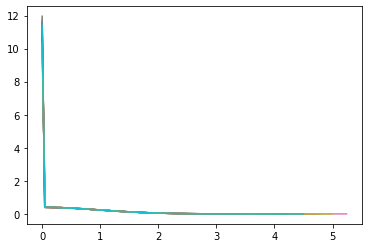

In [53]:
layer_stats2(torch.relu)

In [55]:
n_hidden = 100
model = Sequential([
    Linear(       2, n_hidden, bias=False), BatchNorm1d(n_hidden), Sigmoid(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Sigmoid(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Sigmoid(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Sigmoid(),
    Linear(n_hidden,        2)
])

# 参数初始化的优化
with torch.no_grad():
    for layer in model.layers:
        if isinstance(layer, Linear):
            in_features, out_features = layer.weight.shape
            layer.weight *= 1 / in_features ** 0.5

train_model(model, data, 1)

([0.7270458340644836],
 {0: [tensor(0.0007)],
  1: [tensor(1.0000)],
  2: [tensor(1.)],
  3: [tensor(0.0038)],
  4: [tensor(1.0000)],
  5: [tensor(1.)],
  6: [tensor(0.0027)],
  7: [tensor(1.0000)],
  8: [tensor(1.)],
  9: [tensor(0.0016)],
  10: [tensor(1.0000)],
  11: [tensor(1.)],
  12: [tensor(0.0066)],
  13: [tensor(0.0007)]})

layer 2 mean 0.50 std 0.22 saturation 0.00
layer 5 mean 0.50 std 0.22 saturation 0.00
layer 8 mean 0.50 std 0.22 saturation 0.00
layer 11 mean 0.50 std 0.22 saturation 0.00


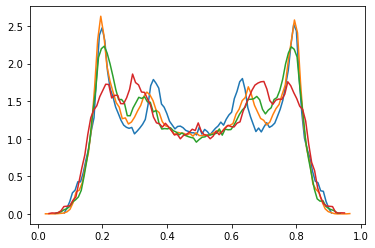

In [56]:
saturation_stats(model)

layer 0 mean -0.00 std 0.05 grad_ratio 0.07
layer 3 mean 0.00 std 0.04 grad_ratio 0.38
layer 6 mean -0.00 std 0.03 grad_ratio 0.27
layer 9 mean 0.00 std 0.02 grad_ratio 0.16


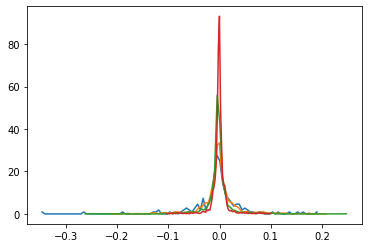

In [57]:
grad_stats(model)

In [58]:
_, ud = train_model(model, data, 100)

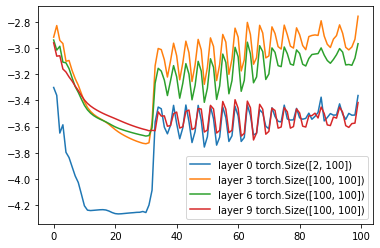

In [59]:
grad_ratio_plot(model)

In [60]:
class LayerNorm1d:
    # x : (B, f)
    
    def __init__(self, dim, eps=1e-5):
        self.eps = eps
        self.gamma = torch.ones(dim, requires_grad=True)  # (f)
        self.beta = torch.zeros(dim, requires_grad=True)  # (f)
        
    def __call__(self, x):
        # x : (B, f)
        xmean = x.mean(1, keepdim=True)  # (B, 1)
        xvar = x.var(1, keepdim=True)    # (B, 1)
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # (B, f)
        self.out = self.gamma * xhat + self.beta  # (B, f)
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

In [63]:
@torch.no_grad()
def layer_stats3(func):
    x = torch.randn(300, 1000)
    for t in range(10):
        l = Linear(1000, 1000, bias=False)
        b = LayerNorm1d(1000)
        #in_features, _ = l.weight.shape
        # 初步优化
        #l.weight *= 1 / in_features ** 0.5
        # 做进一步的优化
        #l.weight *= calculate_gain
        x = func(b(l(x)))
        hy, hx = torch.histogram(x, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        print(f'layer {t} mean {x.mean():.2f} std {x.std():.2f}')

layer 0 mean 0.50 std 0.21
layer 1 mean 0.50 std 0.21
layer 2 mean 0.50 std 0.21
layer 3 mean 0.50 std 0.21
layer 4 mean 0.50 std 0.21
layer 5 mean 0.50 std 0.21
layer 6 mean 0.50 std 0.21
layer 7 mean 0.50 std 0.21
layer 8 mean 0.50 std 0.21
layer 9 mean 0.50 std 0.21


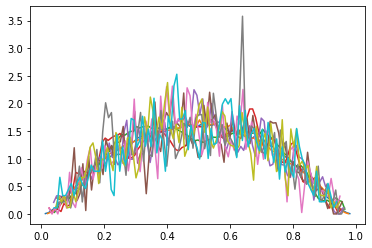

In [65]:
layer_stats3(torch.sigmoid)